In [2]:
# ---------CASO B: Vuelo rectilíneo y simétrico: T cte y V variable y grande-----------
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones

Se trata de un caso simple para comenzar a utilizar la técnica propuesta por Sindy en el ámbito de la mecánica de vuelo.

Las **ecuaciones dinámicas** son las siguientes:
$$
D = -mg\sin{\gamma} \\
L = mg\cos{\gamma}
$$
Las **ecuaciones cinemáticas** son las siguientes:
$$
\dot{x_e} =  V\cos{\gamma} \\
\dot{h} =  V\sin{\gamma}
$$

Este será el único caso en el que se tratará de obtener las ecuaciones cinemáticas y no las dinámicas. La suposición que se realiza es que el ángulo de asiento de la velocidad es constante

## Variables globales

In [3]:
n = 10000
deltat = 0.1
""" t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i """
t = np.arange(0, int(n*deltat), deltat)
N_SIMS = 10
print(t.shape[0], t)

10000 [0.000e+00 1.000e-01 2.000e-01 ... 9.997e+02 9.998e+02 9.999e+02]


In [4]:
def initial_guess(lib):
    data = [np.ones((n, 4)), np.ones((n, 4))]
    print(data[0].shape, data[0].reshape(-1, 1).shape)
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['gamma', 'x', 'h', 'v'])
    print(list_names)

    return np.ones((data[0].shape[1], n_features))

In [5]:
def plot_trajec(t, mod):
    f, ax = plt.subplots(2,2,figsize=(16,18))

    labels = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    # compruebo lo resultados para una condicion inicial que ya "ha visto"

    for i, a in enumerate(ax.ravel()):
        
        a.plot(t, mod.data_val_adim[:,i], 'k', label='Trayectoria real')
        a.plot(t, mod.x_sim[:, i], 'b--', label='Trayectoria simulada')
        
        a.set_title(labels[i], fontsize=20)

        a.tick_params(axis='both', which='major', labelsize=12)
        a.legend(fontsize=14)

    ax[1,0].set_xlabel("Tiempo (s)", fontsize=14)
    ax[1,1].set_xlabel("Tiempo (s)", fontsize=14)

## Funciones

In [6]:
def plot_ntraj(n_trayec, errors, 
            labs=['Nada', 'Con initial_guess']):
    # lista errors: sin aplicar otro tipo de entrada, con cond inic, con restris y completo 
    fig, axs = plt.subplots(2, 2, figsize=(17, 13))
    fig.suptitle("Análisis sobre el número de trayectorias", fontsize=18)
    
    errors_mean = []
    for err in errors:    
        errors_mean.append(np.mean(err, axis=2))

    name = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    
    for j, err in enumerate(errors_mean):
        for i, a in enumerate(axs.ravel()):
            a.set_title(name[i], fontsize=16)
            a.semilogy(n_trayec, np.median(err[:, :, i], axis=0), label=labs[j])
            a.set_xlabel('Número de trayectorias', fontsize=16)
            a.set_ylabel('Error cuadrático medio', fontsize=16)
            a.legend(fontsize=12)
            a.tick_params(axis='both', labelsize=14)

In [7]:
def plot_error_vs_tiempo(t, errors, trayecs, labs=['nada', 'initial_guess']):
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    name = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    
    for z, err in enumerate(errors):
        for i, a in enumerate(axs.ravel()):
            a.set_title(name[i])
            a.set_xlabel('Tiempo (s)')
            a.set_ylabel('Mediana del error')
            err_simp = err[:, :, :, i]
            for j, n in enumerate(trayecs):
                lab = str(n) + ' trayec' + labs[z]
                a.plot(t, np.median(err_simp[:, j], axis=0), label=lab)
            a.legend()

In [8]:
def plot_error_vs_tiempo_val(t, errors, n_trayec, 
        labs=['nada', 'con initial_guess']):
    fig, axs = plt.subplots(2, 2, figsize=(15, 9))
    name = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    fig.suptitle("Análisis sobre tiempos de validación mayores", fontsize=18)
    for z, err in enumerate(errors):
         for j, a in enumerate(axs.ravel()):
            a.set_title(name[j], fontsize=16)
            a.set_xlabel('Tiempo de validacion(s)', fontsize=16)
            a.set_ylabel('Mediana del error', fontsize=16)
            
            err_simp = err[:, :, :, j]
            for i, n in enumerate(n_trayec):
                lab = str(n) + ' trayec+' + labs[z]
                a.semilogy(t, np.median(err_simp[:, i], axis=0), label=lab)
            a.legend(fontsize=12)
            a.tick_params(axis='both', labelsize=14)

In [9]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    name = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    fig, axs = plt.subplots(2, 2, figsize=(15, 7))
    fig.suptitle("Evolución error según pot ruido", fontsize=14)

    for j, a in enumerate(axs.ravel()):
        a.title.set_text(name[j])
        a.set_xlabel('Pot ruido')
        a.set_ylabel('Mediana del error')
           
        err_simp = error[:, :, :, j]
        for i, n in enumerate(n_trayec):
            lab = str(n) + ' trayec' 
            a.plt.semilogx(pots, np.median(err_simp[:, i], axis=0), label=lab)
            a.legend()

In [10]:
def plot_precision_tiempo(error, muestras, tiempos):
    name = ['Ángulo de asiendo de la velocidad (rad)', 'Distancia horizontal (m)', 'Altura (m)'
            , 'Velocidad (m/s)']
    #fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    T, M = np.meshgrid(tiempos, muestras)
    
    for j in range(error.shape[-1]): 
        fig, axs = plt.subplots(figsize=(15, 7))
        ax = Axes3D(fig)
        ax.set_title(name[j])
        ax.set_xlabel('Tiempo máximo de entrenamiento')
        ax.set_ylabel('Número de muestras')
        ax.set_zlabel('Error cuadrático medio')
        ax.plot_surface(T, M, np.median(error[:, :, :, j], axis=0), cmap="coolwarm")
        ax.legend()

    

## Generar gráficas

In [11]:
n_trayectorias_test = [1, 2, 3, 4, 5, 10]
n_sims = N_SIMS
len_traj = t.shape[0]
x0 = [20, 200, 2000, 100]


errors = []
models = [utils.Model_params(feature_list=['gamma', 'x', 'h', 'v'], lib=utils.custom_ecs_A())]
for mod in models:
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 4))
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t, [None], x0, adim=False, 
                        print_model=False, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
        if n_trayectorias_test[i] == 10:
            #plot_trajec(t, mod_class)
            model10 = mod_class.model_sindy
    
    errors.append(error)

model10.print(lhs=["gamma'", "x'", "h'", "v'"])

ahora
gamma' = 0.000
x' = 1.000 v*cos(gamma)
h' = 1.000 +v*sen(gamma)
v' = 0.000


In [ ]:
n_trayectorias_test = [1, 2, 3, 4, 5, 10]
n_sims = N_SIMS
len_traj = t.shape[0]
x0 = [20, 200, 2000, 100]


errors = []
models = [None, utils.Model_params(lib=utils.custom_ecs_A(), initial_guess=initial_guess(utils.custom_ecs_A()))]
for mod in models:
    print('ahora', flush=True)
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 4))
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t, [None], x0, adim=False, 
                        print_model=False, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
        if n_trayectorias_test[i] == 10:
            plot_trajec(t, mod_class)
    
    errors.append(error)


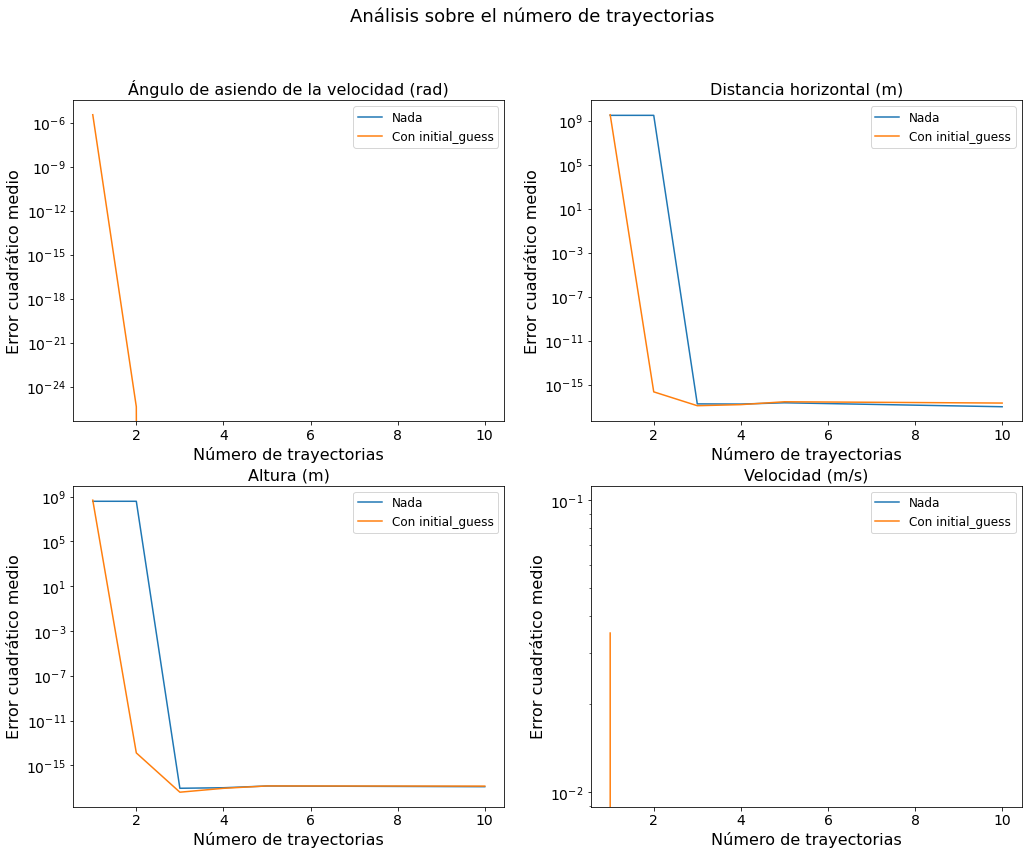

In [67]:
# Representar
plot_ntraj(n_trayectorias_test, errors)

In [70]:
# error vs tiempo
n_trayectorias_test = [10, 20, 40, 60]
n_sims = N_SIMS*2
len_traj = t.shape[0]
x0 = [20, 200, 2000, 100]


models = [None, ]
        #utils.Model_params(initial_guess=initial_guess(utils.custom_ecs_A()), lib=utils.custom_ecs_A(), opt=1)]


error = np.zeros((n_sims, len(n_trayectorias_test), t.shape[0], 4)) 
errors3 = []
for mod in models:
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t, [None], x0, 
                                        adim=False, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
    errors3.append(error)

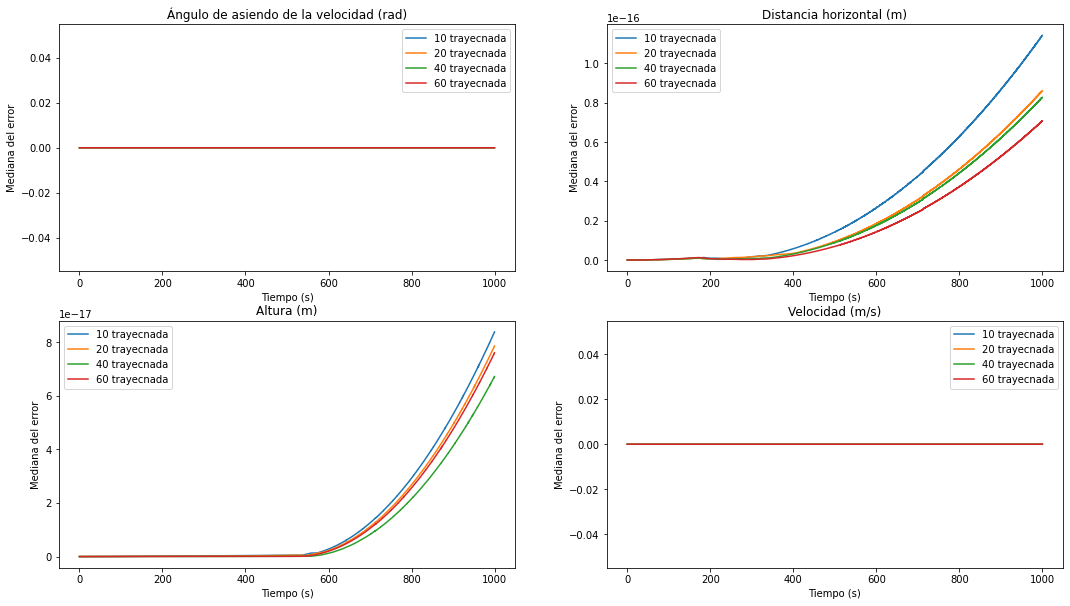

In [71]:
# Representar
plot_error_vs_tiempo(t, errors3, n_trayectorias_test)

In [42]:
#tiempos de validacion mas largos:

n_trayectorias_test = [10]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1] - t[0]
# t_val = np.arange(0, int(n*3*deltat), deltat)
# t_val2 = np.arange(0, int(n*3*deltat_train), deltat_train)

models = [None, 
            utils.Model_params(initial_guess=initial_guess(utils.custom_ecs_A()), 
            lib=utils.custom_ecs_A(), opt=1)]
errors4 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4))  
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoA, n_trayectorias_test[i], t,
                                            [None], x0, 
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors4.append(error)


(10000, 4) (40000, 1)
['+x*sen(gamma)', '+h*sen(gamma)', '+v*sen(gamma)', '+h*sen(x)', '+v*sen(x)', '+v*sen(h)', 'x*cos(gamma)', 'h*cos(gamma)', 'v*cos(gamma)', 'h*cos(x)', 'v*cos(x)', 'v*cos(h)']


/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


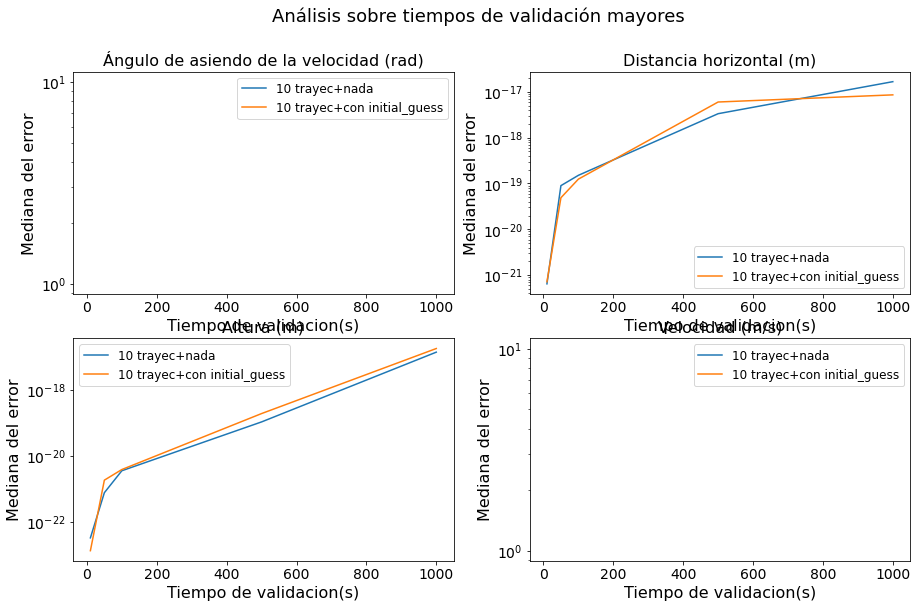

In [43]:
plot_error_vs_tiempo_val(tiempos_val, errors4, n_trayectorias_test)

In [56]:
# pruebo con otras librerías: polinomica

labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=3)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS*2
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1] - t[0]

#assert n2 == len_traj

models = [None, ]
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_pol = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 4))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), t.shape[0], 4))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t,
                                        [None], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
         
    errors_pol.append(error)

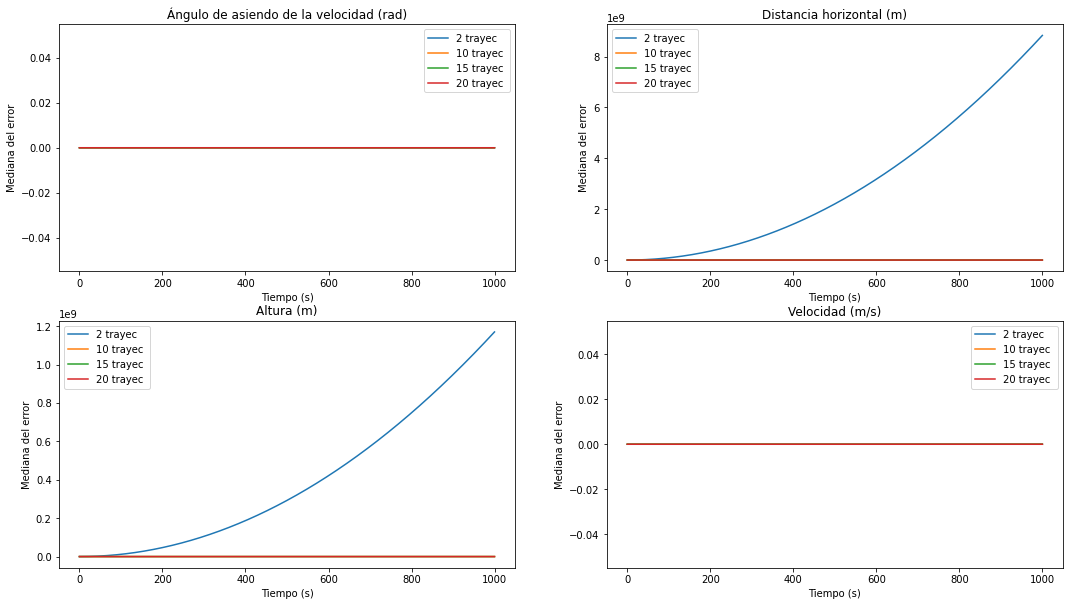

In [57]:
plot_error_vs_tiempo(t, errors_pol, n_trayectorias_test, labs=[' '])

/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


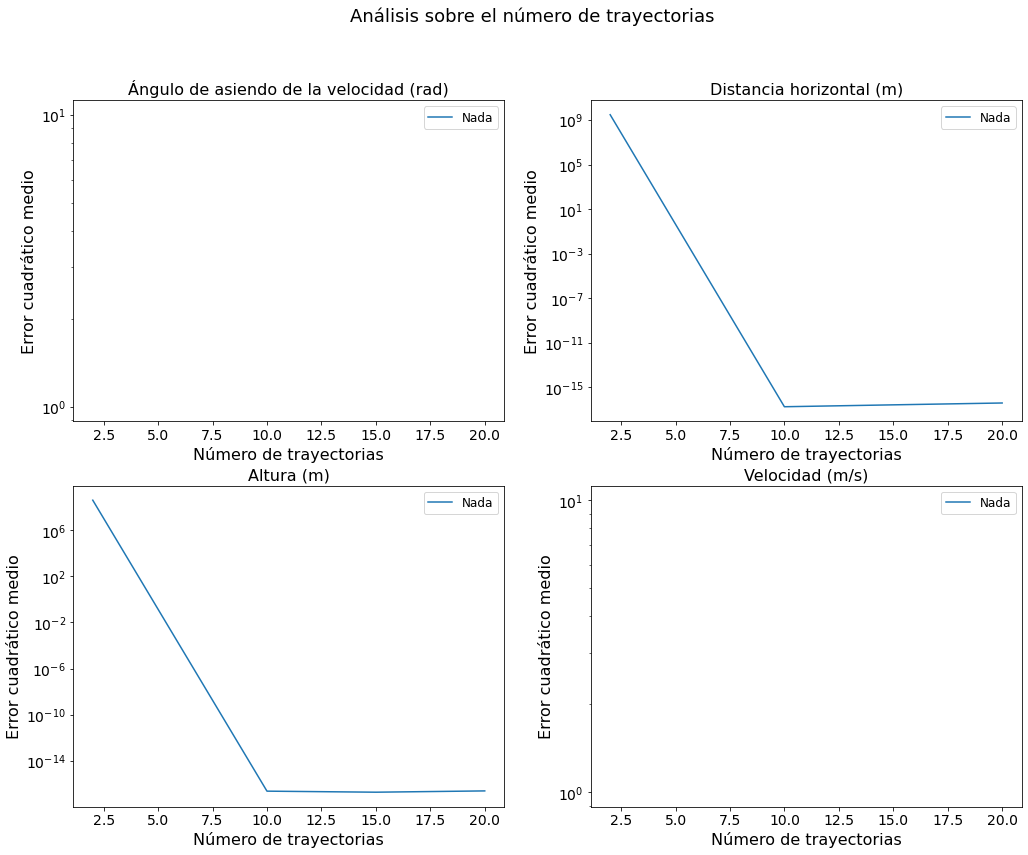

In [58]:
plot_ntraj(n_trayectorias_test, errors_pol) 

In [59]:
# pruebo con otras librerías: fourier
labs=['nada', 'initial_guess']
lib = ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS*2
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1] - t[0]
len_traj = t.shape[0]

models = [None, ]
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_fou = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 4))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 4))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t,
                                        [None], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
         
    errors_fou.append(error)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


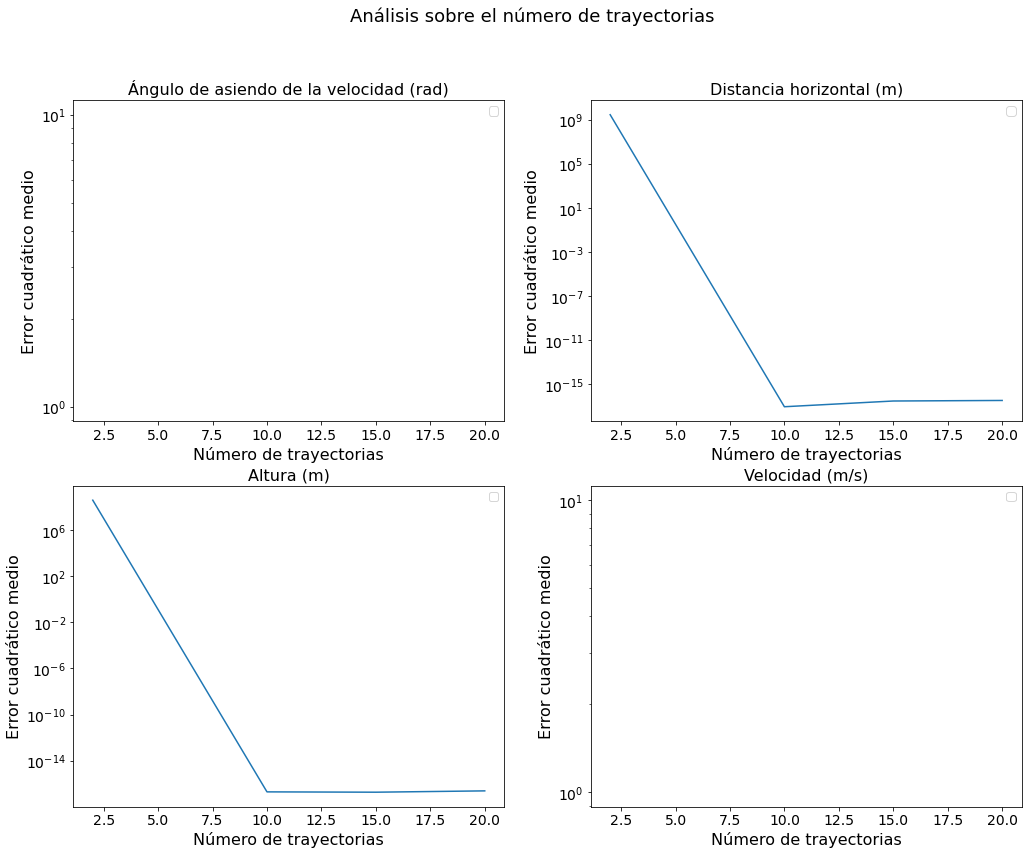

In [60]:
plot_ntraj(n_trayectorias_test, errors_fou, labs=[''])  

In [62]:
# pruebo con otras librerías: polinomica + fourier
labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=2) + ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
len_traj = t.shape[0]

models = [None, ] 
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_pf = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 4))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 4))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], t, 
                                        [None], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t)
         
    errors_pf.append(error)

nada


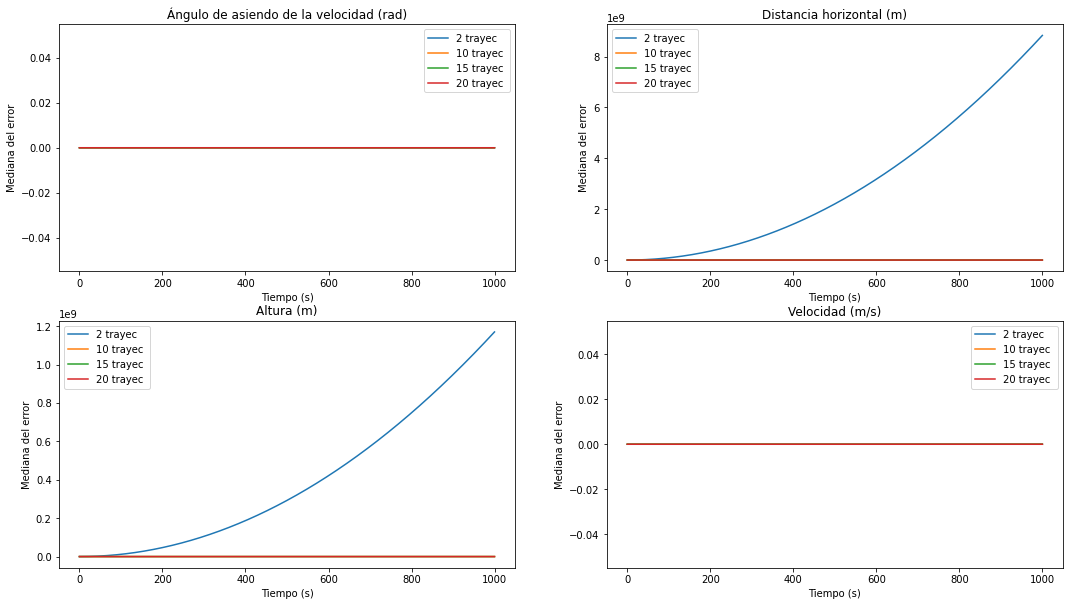

In [63]:
plot_error_vs_tiempo(t, errors_pf, n_trayectorias_test, labs=[' '])

/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


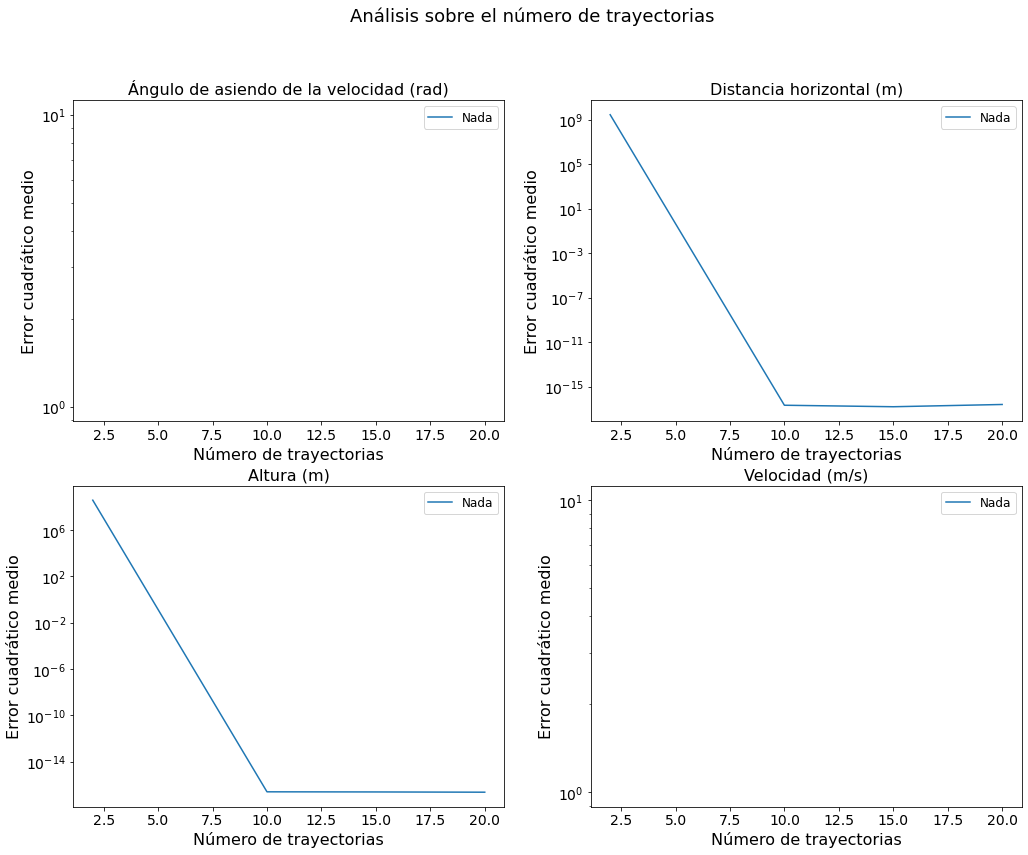

In [64]:
plot_ntraj(n_trayectorias_test, errors_pf)  

In [65]:
# obtengo el error con ruido en las muestras
labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [2, 10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

models = [None, 
            utils.Model_params(deltat=deltat_train,  
            initial_guess= initial_guess(utils.custom_ecs_A()), lib=utils.custom_ecs_A(), opt=1)]
errors5 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4))  
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoA, n_trayectorias_test[i], t,
                                            [None], x0, ruido=0.01,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors5.append(error)



(10000, 4) (40000, 1)
['+x*sen(gamma)', '+h*sen(gamma)', '+v*sen(gamma)', '+h*sen(x)', '+v*sen(x)', '+v*sen(h)', 'x*cos(gamma)', 'h*cos(gamma)', 'v*cos(gamma)', 'h*cos(x)', 'v*cos(x)', 'v*cos(h)']
nada


/home/mdiaz/.local/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plot_error_vs_tiempo_val(t, errors5, n_trayectorias_test)

In [ ]:
# obtengo el error con ruido en las muestras
labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [2, 10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

models = [None,
            utils.Model_params(deltat=deltat_train,  
            initial_guess= initial_guess(utils.custom_ecs_A()), lib=utils.custom_ecs_A(), opt=1)]
errors6 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4)) 

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 4)) 
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
           
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoA, n_trayectorias_test[i], t,
                                            [None], x0, ruido=0.0003,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors6.append(error)

In [ ]:
plot_error_vs_tiempo_val(t, errors6, n_trayectorias_test)

In [ ]:
# error vs potencia de ruido en las muestras sin initial_guess

n_trayectorias_test = [5, 10, 15]
n_sims = N_SIMS
x0 = [20, 200, 2000, 100] #v0 y gamma0 en grados, de validacionn
pots_ruido = [1e-4, 1e-3, 1e-2, 0.1]
deltat_train = t[1] - t[0]
 
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido), 4))

for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoA, n_trayectorias_test[i], 
                                            t, [None], x0,
                                            adim=False, deltat_train=deltat_train, ruido=pots_ruido[z])
            error7[j,i,z, :] = mod_class.error_trayec(t).mean(axis=0)
            print(pots_ruido[z])


In [ ]:
# Representar pot ruido vs error con ruido
plot_error_vs_pot_ruido(error7, n_trayectorias_test, pots_ruido)